### XGBoost Regressor

In [22]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shap
import xgboost
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)

In [4]:
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
pd.DataFrame(ord_enc.fit_transform(X_display))

,0,1,2,3,4,5,6,7,8,9,10,11
0,22.0,7.0,12.0,4.0,1.0,1.0,4.0,1.0,25.0,0.0,39.0,39.0
1,33.0,6.0,12.0,2.0,4.0,0.0,4.0,1.0,0.0,0.0,12.0,39.0
2,21.0,4.0,8.0,0.0,6.0,1.0,4.0,1.0,0.0,0.0,39.0,39.0
3,36.0,4.0,6.0,2.0,6.0,0.0,2.0,1.0,0.0,0.0,39.0,39.0
4,11.0,4.0,12.0,2.0,10.0,5.0,2.0,0.0,0.0,0.0,39.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,10.0,4.0,11.0,2.0,13.0,5.0,4.0,0.0,0.0,0.0,37.0,39.0
32557,23.0,4.0,8.0,2.0,7.0,0.0,4.0,1.0,0.0,0.0,39.0,39.0
32558,41.0,4.0,8.0,6.0,1.0,4.0,4.0,0.0,0.0,0.0,39.0,39.0
32559,5.0,4.0,8.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,19.0,39.0


### XGBoost Classifier Using GridsearchCV(Drop Sex Column)

In [5]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def group_difference(output, group_label, labels, title_, xmin, xmax, xlabel,  apply_sigmoid=False):
    # compute confidence bounds for the group difference value
    vs = []
    idx_a, idx_b = (group_label == 0), (group_label == 1)
    gmean = np.mean(idx_b)
    for i in range(200):
        r = np.random.rand(output.shape[0]) > gmean
        vs.append(output[r].mean(0) - output[~r].mean(0))
    vs = np.array(vs)
    xerr = np.vstack([np.percentile(vs, 95, axis=0), np.percentile(vs, 5, axis=0)])

    # compute group difference value across two groups:
    a = np.mean(output[idx_a,:], axis=0)
    b = np.mean(output[idx_b,:], axis=0)
    if apply_sigmoid:
        diff = sigmoid(b) - sigmoid(a)
    else:
        diff = b-a
        
    sorted_idx = np.argsort(np.abs(diff)).astype(np.int)
    diff = diff[sorted_idx]
    xerr = xerr[:,sorted_idx]
    labels = labels[sorted_idx]
    if len(diff) == 1:
        print('diff:', np.round(diff[0], 3))
    
    # plot
    figsize = [6.4, 0.2 + 0.9 * len(labels)]
    plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.title(title_)
    plt.barh(labels, 
             diff, 
             xerr=np.abs(xerr),
             capsize=3,
             color=shap.plots.colors.blue_rgb)
    plt.xlim((xmin, xmax))
    plt.xlabel(xlabel)
    plt.show()

In [74]:
## Train-test split
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = 2022)
sex_train, sex_test =X_train["Sex"], X_test["Sex"]
X_train = X_train.drop(["Sex"],axis = 1)
X_test = X_test.drop(["Sex"],axis = 1)


In [7]:
## Scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
xgbr = xgboost.XGBClassifier(seed = 2022)

params={"max_depth": [3,6,9,12], "n_estimators":[100, 300, 500], "learning_rate" : [0.01, 0.05,0.1,0.2],'objective':['binary:logistic'], "eval_metric" : ["logloss"]}

model = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   verbose=1,n_jobs = -1)
model.fit(X_train, y_train)
print("Best parameters:", model.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'objective': 'binary:logistic'}


F1 Score for best model: 0.712
Accuracy for best model: 0.873


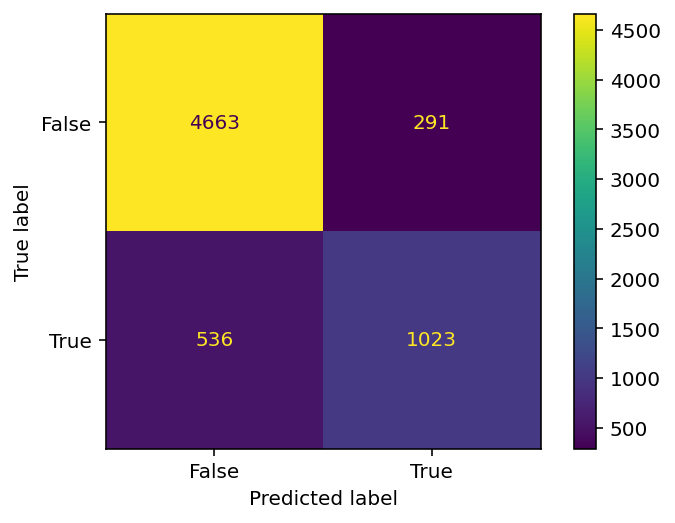

In [9]:
import shap
from sklearn.metrics import f1_score
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.metrics import plot_confusion_matrix
best_model = model.best_estimator_
y_pred = best_model.predict(X_test)
plot_confusion_matrix(best_model, X_test, y_test)
print("F1 Score for best model:", "{0:.3f}".format(f1_score(y_test,y_pred)))
print("Accuracy for best model:", "{0:.3f}".format(accuracy_score(y_test,y_pred)))

In [10]:
model1 = model.best_estimator_
explainer = shap.TreeExplainer(model1, X_train)
shap_values = explainer.shap_values(X_train)


 99%|===================| 25840/26048 [01:39<00:00]        

In [33]:
shap_values[sex_train == 0]

array([[ 7.02914976e-01,  4.32790249e-02,  6.75532868e-01, ...,
         7.84054724e-03,  9.45136994e-01, -8.29750490e-04],
       [-2.40505463e+00, -1.16909579e-02, -9.49563441e-02, ...,
        -2.50897232e-02, -1.68842443e+00, -4.66030717e-03],
       [ 4.17719896e-02,  1.21475610e-02,  1.56439989e-01, ...,
        -3.11708687e-03, -4.83752745e-02,  1.18493596e-02],
       ...,
       [ 7.21588053e-01,  2.12497656e-01, -3.69609144e-01, ...,
         2.64768726e-03, -8.00102449e-01, -1.51530291e-02],
       [ 3.80677686e-01,  1.37891094e-02,  8.12431349e-01, ...,
        -2.24676050e-02,  4.21061645e-02,  1.39729398e-02],
       [ 1.04451591e+00,  1.68363141e-03,  1.03028046e+00, ...,
        -2.88146815e+00,  6.53252885e-01,  7.87453259e-04]])

diff: 0.478


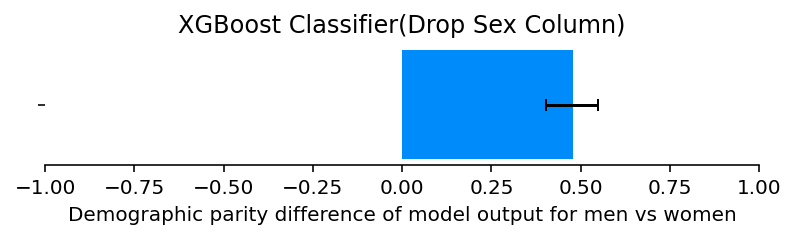

In [11]:
model_outputs = explainer.expected_value + shap_values.sum(1)
glabel = "Demographic parity difference of model output for men vs women"
title = "XGBoost Classifier(Drop Sex Column)"
xmin = -1
xmax = 1
g1 = group_difference(shap_values.sum(1, keepdims=True), sex_train,np.array(['']),title,xmin=xmin, xmax=xmax, xlabel=glabel,apply_sigmoid=True)
g1

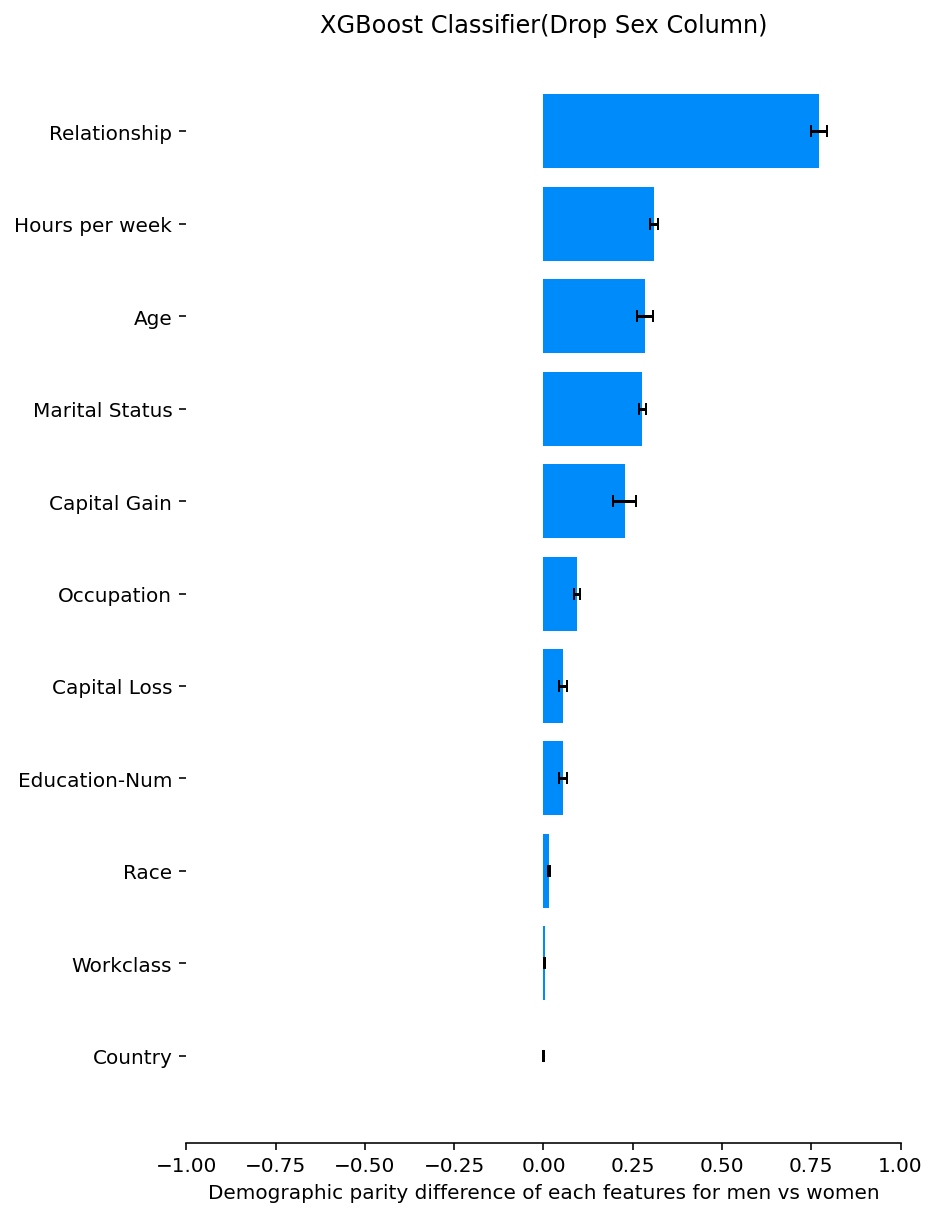

In [19]:
slabel = "Demographic parity difference of each features for men vs women"
title = "XGBoost Classifier(Drop Sex Column)"
g2 = group_difference(shap_values, sex_train, scaler.get_feature_names_out(),title,xmin, xmax, xlabel=slabel)
g2

### XGBoost Classifier Using GridsearchCV(Drop Sex & Relationship Column)

In [14]:
##Train-test split and drop columns
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = 2022)
sex_train, sex_test =X_train["Sex"], X_test["Sex"]
X_train = X_train.drop(["Sex","Relationship"],axis = 1)
X_test = X_test.drop(["Sex","Relationship"],axis = 1)


In [15]:
## scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
scaler.get_feature_names_out()

array(['Age', 'Workclass', 'Education-Num', 'Marital Status',
       'Occupation', 'Race', 'Capital Gain', 'Capital Loss',
       'Hours per week', 'Country'], dtype=object)

In [17]:
xgbr = xgboost.XGBClassifier(seed = 2022)

params={"max_depth": [3,6,9,12], "n_estimators":[100, 300, 500], "learning_rate" : [0.01, 0.05,0.1,0.2],'objective':['binary:logistic'], "eval_metric" : ["logloss"]}

model = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   verbose=1,n_jobs = -1)
model.fit(X_train, y_train)
print("Best parameters:", model.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'eval_metric': 'logloss', 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100, 'objective': 'binary:logistic'}


F1 Score for best model: 0.713
Accuracy for best model: 0.873


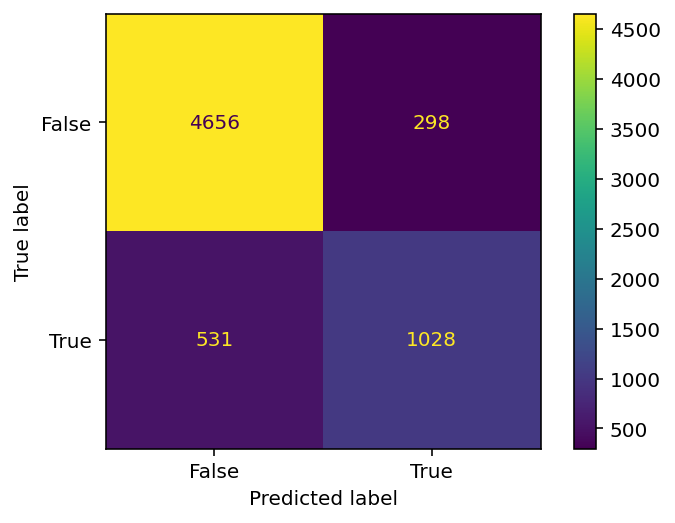

In [18]:
import shap
from sklearn.metrics import f1_score
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.metrics import plot_confusion_matrix
best_model = model.best_estimator_
y_pred = best_model.predict(X_test)
plot_confusion_matrix(best_model, X_test, y_test)
print("F1 Score for best model:", "{0:.3f}".format(f1_score(y_test,y_pred)))
print("Accuracy for best model:", "{0:.3f}".format(accuracy_score(y_test,y_pred)))

In [19]:
model1 = model.best_estimator_
explainer = shap.TreeExplainer(model1, X_train)
shap_values = explainer.shap_values(X_train)

 99%|===================| 25666/26048 [00:53<00:00]        

diff: 0.492


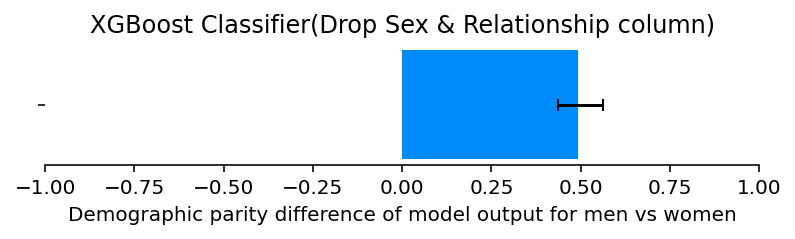

In [20]:
model_outputs = explainer.expected_value + shap_values.sum(1)
glabel = "Demographic parity difference of model output for men vs women"
title = "XGBoost Classifier(Drop Sex & Relationship column)"
xmin = -1
xmax = 1
g3 = group_difference(shap_values.sum(1, keepdims=True), sex_train,np.array(['']),title,xmin=xmin, xmax=xmax, xlabel=glabel,apply_sigmoid=True)
g3

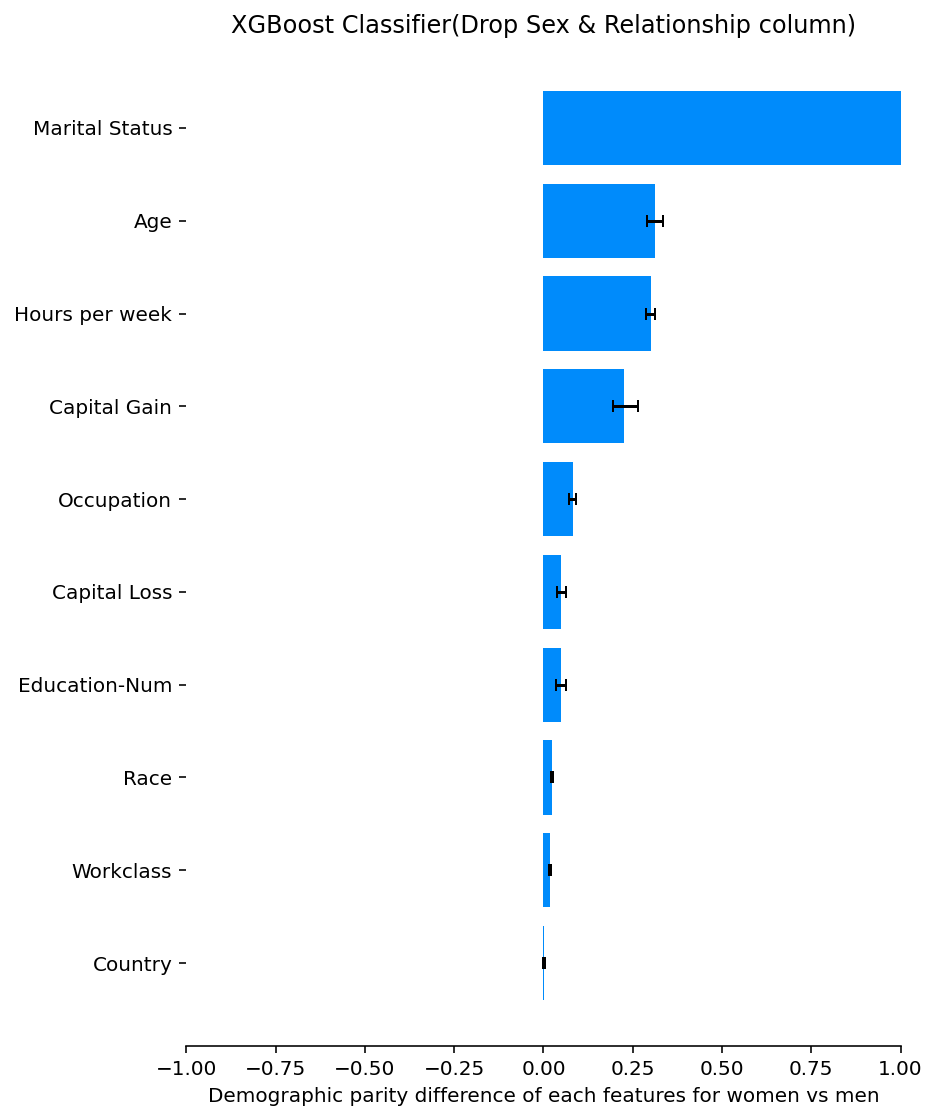

In [21]:
slabel = "Demographic parity difference of each features for men vs women"
title = "XGBoost Classifier(Drop Sex & Relationship column)"
g4 = group_difference(shap_values, sex_train, scaler.get_feature_names_out(),title,xmin, xmax, xlabel=slabel)
g4

In [ ]:
slabel = "Demographic parity difference of each features for men vs women"
title = "XGBoost Classifier(Drop Sex & Relationship column)"
g4 = shap.group_difference_plot(shap_values, sex_train, scaler.get_feature_names_out(), xmin=-2, xmax=2, xlabel=slabel)
g4

### XGBoost Classifier Using GridsearchCV(Drop Sex & Relationship & Marital Status Columns)

In [22]:
##Train-test split and drop columns
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = 2022)
sex_train, sex_test =X_train["Sex"], X_test["Sex"]
X_train = X_train.drop(["Sex","Relationship","Marital Status"],axis = 1)
X_test = X_test.drop(["Sex","Relationship","Marital Status"],axis = 1)


In [23]:
## scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
xgbr = xgboost.XGBClassifier(seed = 2022)

params={"max_depth": [3,6,9,12], "n_estimators":[100, 300, 500], "learning_rate" : [0.01, 0.05,0.1,0.2],'objective':['binary:logistic'], "eval_metric" : ["logloss"]}

model = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   verbose=1,n_jobs = -1)
model.fit(X_train, y_train)
print("Best parameters:", model.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'eval_metric': 'logloss', 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300, 'objective': 'binary:logistic'}


F1 Score for best model: 0.642
Accuracy for best model: 0.854


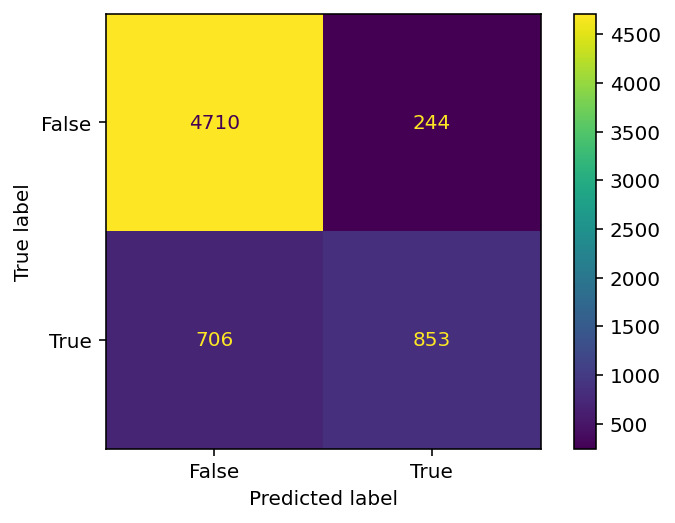

In [25]:
import shap
from sklearn.metrics import f1_score
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.metrics import plot_confusion_matrix
best_model = model.best_estimator_
y_pred = best_model.predict(X_test)
plot_confusion_matrix(best_model, X_test, y_test)
print("F1 Score for best model:", "{0:.3f}".format(f1_score(y_test,y_pred)))
print("Accuracy for best model:", "{0:.3f}".format(accuracy_score(y_test,y_pred)))

In [26]:
model1 = model.best_estimator_
explainer = shap.TreeExplainer(model1, X_train)
shap_values = explainer.shap_values(X_train)

 99%|===================| 25713/26048 [00:55<00:00]        

diff: 0.324


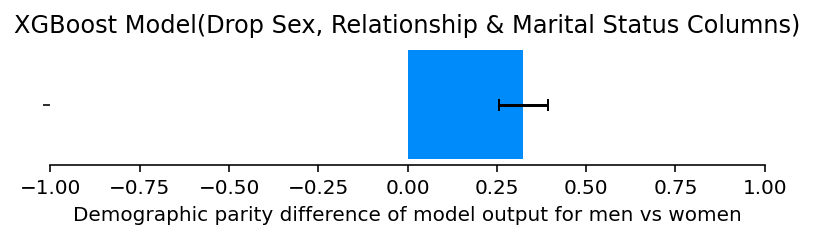

In [27]:
model_outputs = explainer.expected_value + shap_values.sum(1)
glabel = "Demographic parity difference of model output for men vs women"
title = "XGBoost Model(Drop Sex, Relationship & Marital Status Columns)"
xmin = -1
xmax = 1
g5 = group_difference(shap_values.sum(1, keepdims=True), sex_train,np.array(['']),title,xmin=xmin, xmax=xmax, xlabel=glabel,apply_sigmoid=True)
g5

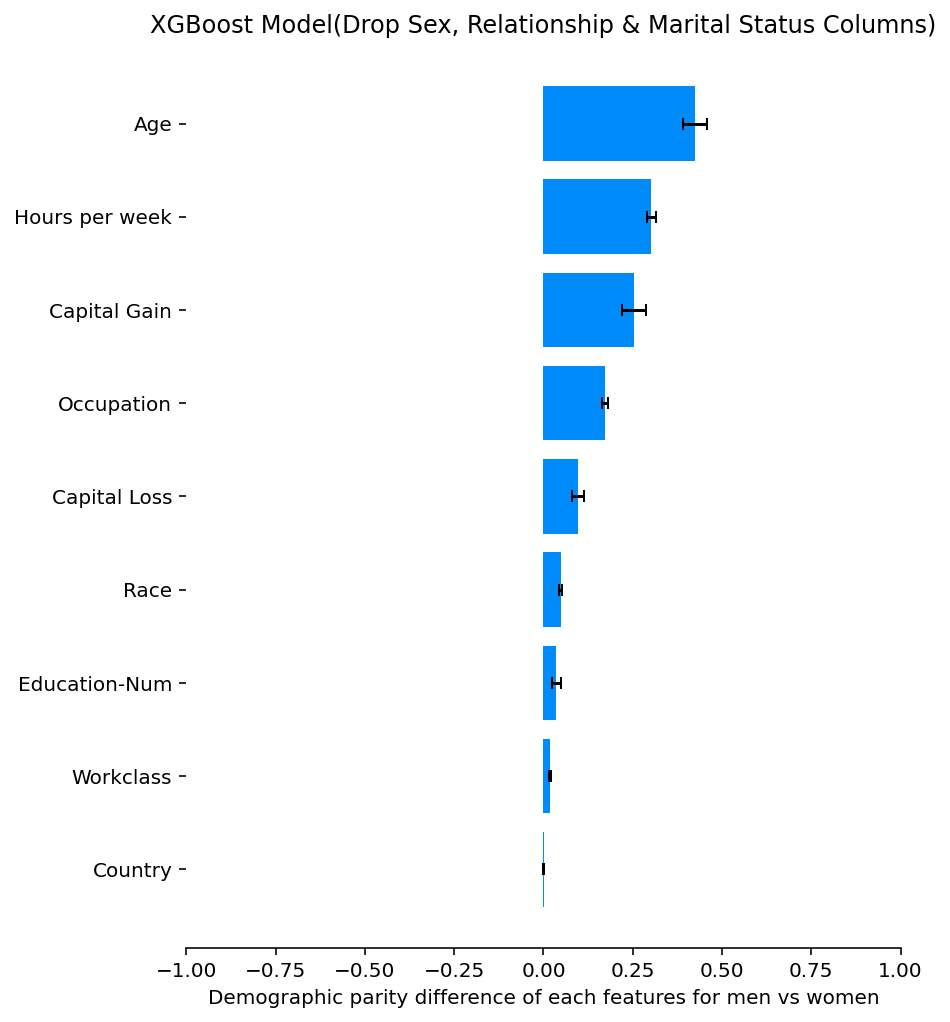

In [28]:
slabel = "Demographic parity difference of each features for men vs women"
title = "XGBoost Model(Drop Sex, Relationship & Marital Status Columns)"
g6 = group_difference(shap_values, sex_train, scaler.get_feature_names_out(),title,xmin, xmax, xlabel=slabel)
g6

### XGBoost Classifier Using GridsearchCV(Drop Sex & Hours Per Week Columns)

In [29]:
##Train-test split and drop columns
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = 2022)
sex_train, sex_test =X_train["Sex"], X_test["Sex"]
X_train = X_train.drop(["Sex","Hours per week"],axis = 1)
X_test = X_test.drop(["Sex","Hours per week"],axis = 1)

In [30]:
## scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
xgbr = xgboost.XGBClassifier(seed = 2022)
## max_depth
params={"max_depth": [3,6,9,12], "n_estimators":[100, 300, 500], "learning_rate" : [0.01, 0.05,0.1,0.2],'objective':['binary:logistic'], "eval_metric" : ["logloss"]}

model = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   verbose=1,n_jobs = -1)
model.fit(X_train, y_train)
print("Best parameters:", model.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'eval_metric': 'logloss', 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300, 'objective': 'binary:logistic'}


F1 Score for best model: 0.715
Accuracy for best model: 0.873


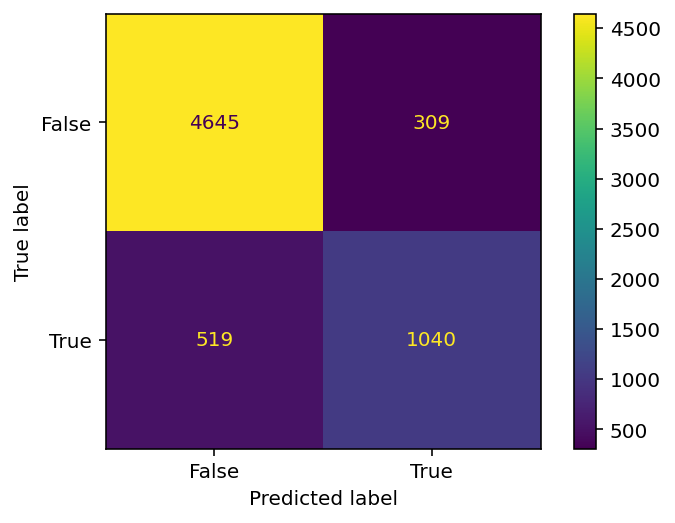

In [32]:

best_model = model.best_estimator_
y_pred = best_model.predict(X_test)
plot_confusion_matrix(best_model, X_test, y_test)
print("F1 Score for best model:", "{0:.3f}".format(f1_score(y_test,y_pred)))
print("Accuracy for best model:", "{0:.3f}".format(accuracy_score(y_test,y_pred)))

In [33]:
model1 = model.best_estimator_
explainer = shap.TreeExplainer(model1, X_train)
shap_values = explainer.shap_values(X_train)

 99%|===================| 25794/26048 [00:58<00:00]        

diff: 0.463


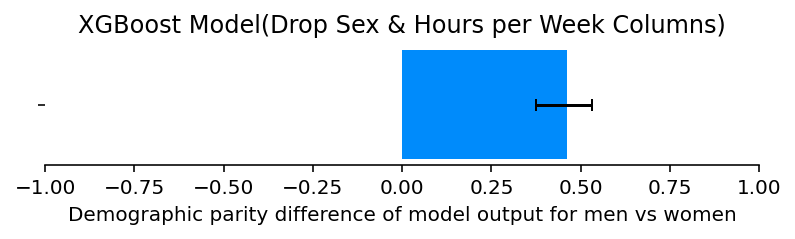

In [34]:
model_outputs = explainer.expected_value + shap_values.sum(1)
glabel = "Demographic parity difference of model output for men vs women"
title = "XGBoost Model(Drop Sex & Hours per Week Columns)"
xmin = -1
xmax = 1
g7 = group_difference(shap_values.sum(1, keepdims=True), sex_train,np.array(['']),title,xmin=xmin, xmax=xmax, xlabel=glabel,apply_sigmoid=True)
g7

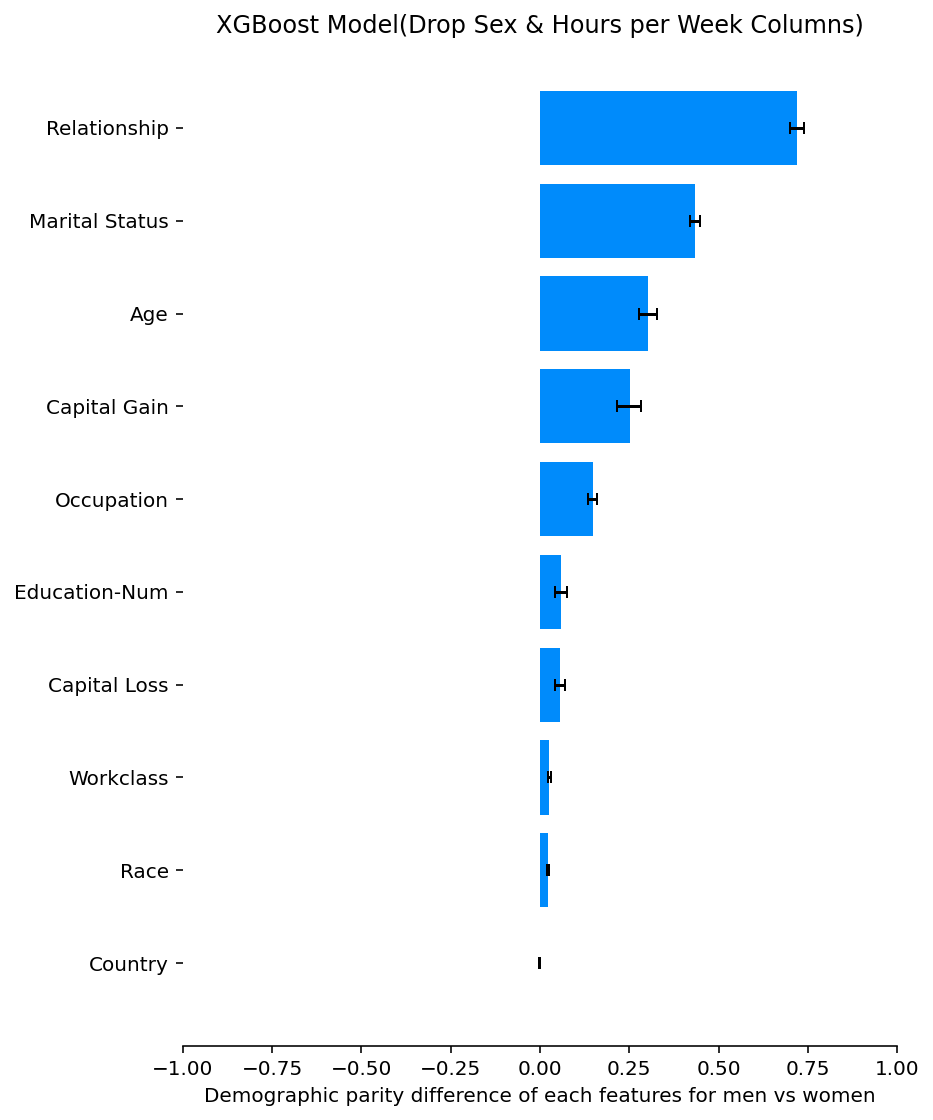

In [35]:
glabel = "Demographic parity difference of model output for men vs women"
title = "XGBoost Model(Drop Sex & Hours per Week Columns)"
g8 = group_difference(shap_values, sex_train, scaler.get_feature_names_out(),title,xmin, xmax, xlabel=slabel)
g8

### XGBoost Classifier Using GridsearchCV(Drop Sex Column) with More Hyperparameter Tunings(Increasing the minimum of max_depth to be tuned)

In [44]:
## Train-test split
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = 2022)
sex_train, sex_test =X_train["Sex"], X_test["Sex"]
X_train = X_train.drop(["Sex"],axis = 1)
X_test = X_test.drop(["Sex"],axis = 1)

In [45]:
## Scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [46]:
xgbr = xgboost.XGBClassifier(seed = 2022)
### added min_child_weight and gamma: minimum loss reduction required to make a split
params={"max_depth": [4,6,8,10],'min_child_weight':[1,3,5], "gamma":[0,0.1,0.2],"n_estimators":[100, 300, 500], "learning_rate" : [0.01, 0.05,0.1,0.2],'objective':['binary:logistic'], "eval_metric" : ["logloss"]}

model = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   verbose=1,n_jobs = -1)
model.fit(X_train, y_train)
print("Best parameters:", model.best_params_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters: {'eval_metric': 'logloss', 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 300, 'objective': 'binary:logistic'}


F1 Score for best model: 0.712
Accuracy for best model: 0.872


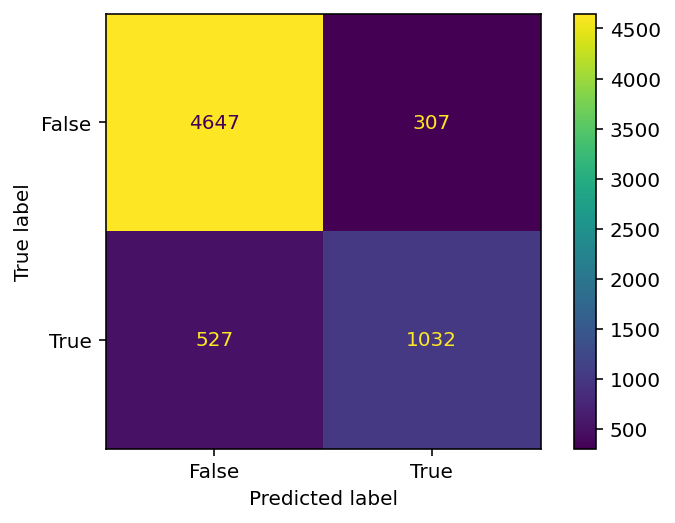

In [47]:
import shap
from sklearn.metrics import f1_score
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.metrics import plot_confusion_matrix
best_model = model.best_estimator_
y_pred = best_model.predict(X_test)
plot_confusion_matrix(best_model, X_test, y_test)
print("F1 Score for best model:", "{0:.3f}".format(f1_score(y_test,y_pred)))
print("Accuracy for best model:", "{0:.3f}".format(accuracy_score(y_test,y_pred)))

diff: 0.478


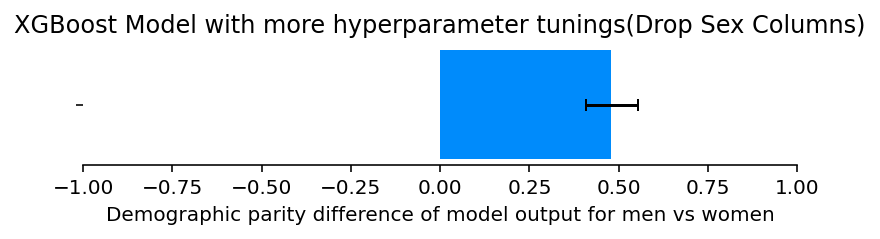

In [48]:
model_outputs = explainer.expected_value + shap_values.sum(1)
glabel = "Demographic parity difference of model output for men vs women"
title = "XGBoost Model with more hyperparameter tunings(Drop Sex Columns)"
xmin = -1
xmax = 1
g9 = group_difference(shap_values.sum(1, keepdims=True), sex_train,np.array(['']),title,xmin=xmin, xmax=xmax, xlabel=glabel,apply_sigmoid=True)
g9

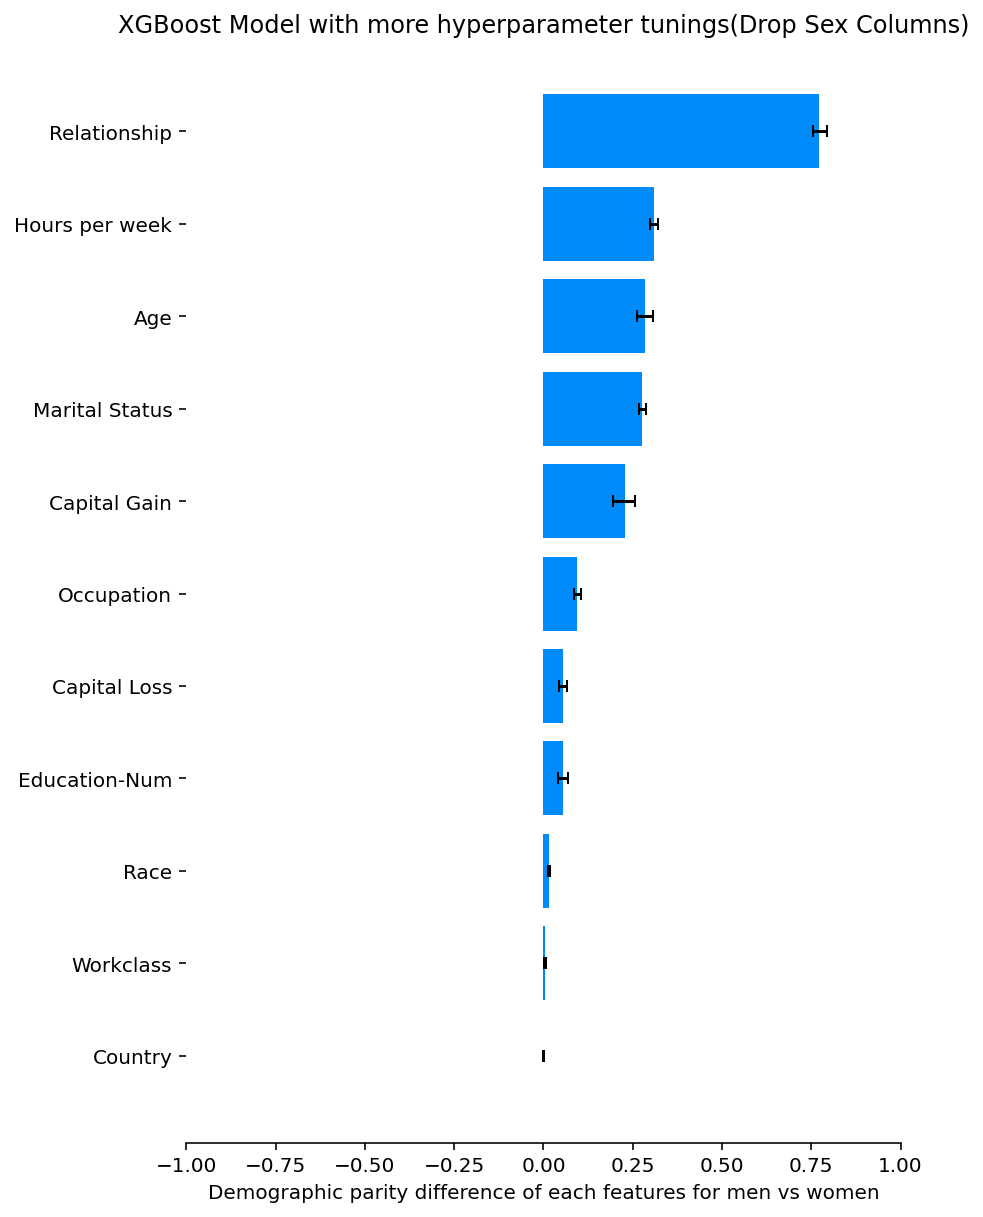

In [49]:
glabel = "Demographic parity difference of model output for men vs women"
title = "XGBoost Model with more hyperparameter tunings(Drop Sex Columns)"
g10 =group_difference(shap_values, sex_train, scaler.get_feature_names_out(),title,xmin, xmax, xlabel=slabel)
g10

In [50]:
xgbr = xgboost.XGBClassifier(seed = 2022)
### max_depth starting at 5, added min_child_weight and gamma: minimum loss reduction required to make a split
params={"max_depth": [5,7,9,11],'min_child_weight':[1,3,5], "gamma":[0,0.1,0.2,0.3],"n_estimators":[100, 300, 500], "learning_rate" : [0.01, 0.05,0.1,0.2],'objective':['binary:logistic'], "eval_metric" : ["logloss"]}

model = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   verbose=1,n_jobs = -1)
model.fit(X_train, y_train)
print("Best parameters:", model.best_params_)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best parameters: {'eval_metric': 'logloss', 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 500, 'objective': 'binary:logistic'}


F1 Score for best model: 0.716
Accuracy for best model: 0.873


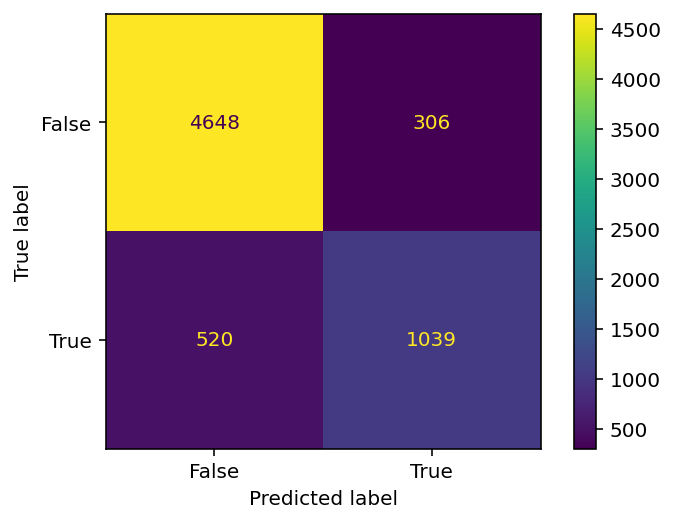

In [51]:
import shap
from sklearn.metrics import f1_score
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.metrics import plot_confusion_matrix
best_model = model.best_estimator_
y_pred = best_model.predict(X_test)
plot_confusion_matrix(best_model, X_test, y_test)
print("F1 Score for best model:", "{0:.3f}".format(f1_score(y_test,y_pred)))
print("Accuracy for best model:", "{0:.3f}".format(accuracy_score(y_test,y_pred)))

diff: 0.478


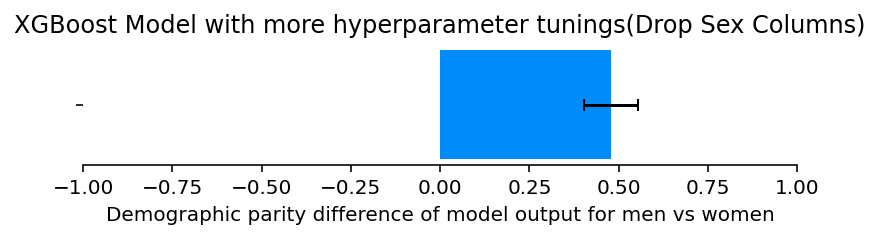

In [52]:
model_outputs = explainer.expected_value + shap_values.sum(1)
glabel = "Demographic parity difference of model output for men vs women"
title = "XGBoost Model with more hyperparameter tunings(Drop Sex Columns)"
xmin = -1
xmax = 1
g11 = group_difference(shap_values.sum(1, keepdims=True), sex_train,np.array(['']),title,xmin=xmin, xmax=xmax, xlabel=glabel,apply_sigmoid=True)
g11

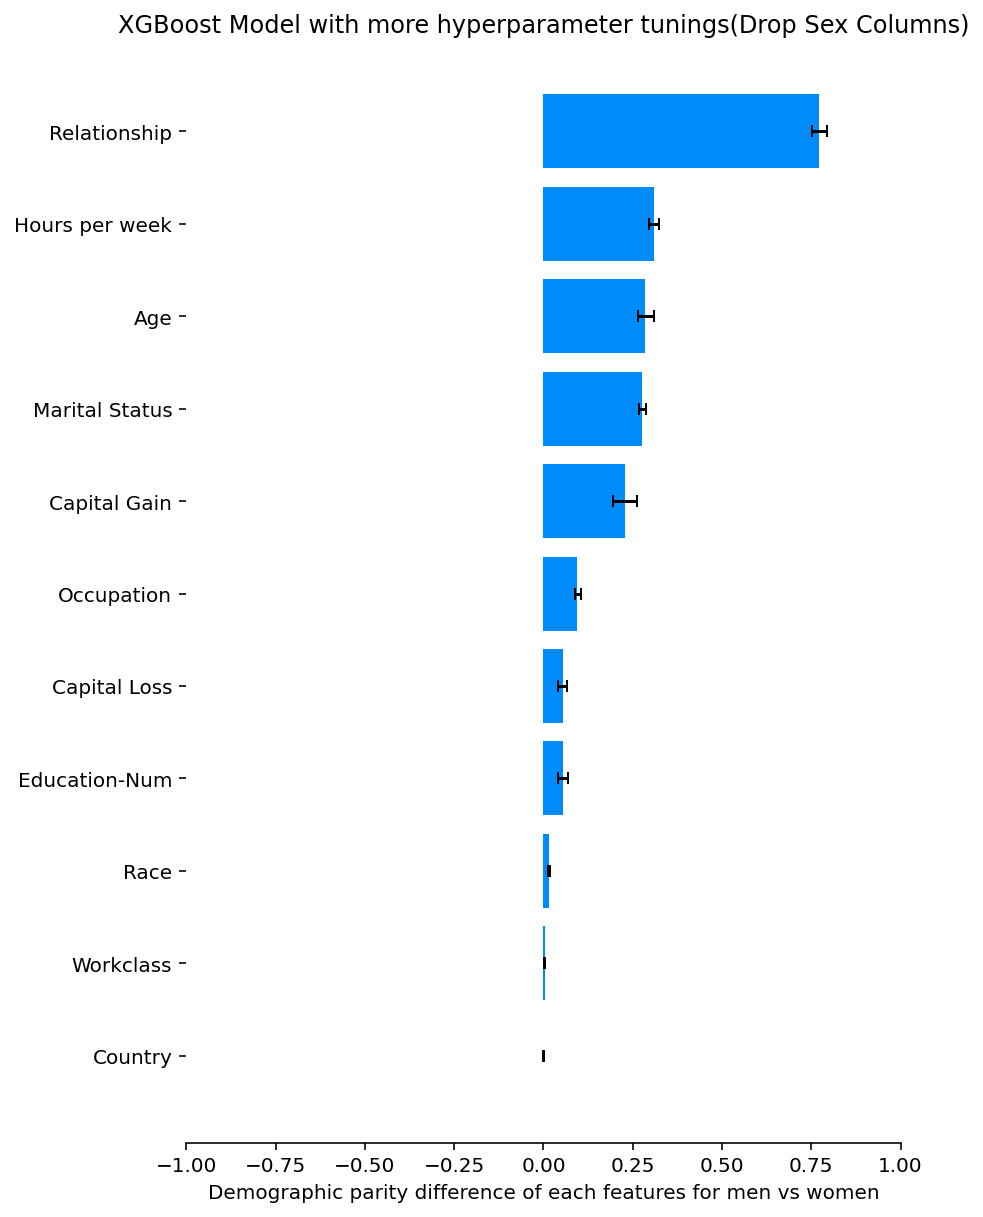

In [53]:
glabel = "Demographic parity difference of model output for men vs women"
title = "XGBoost Model with more hyperparameter tunings(Drop Sex Columns)"
g12 =group_difference(shap_values, sex_train, scaler.get_feature_names_out(),title,xmin, xmax, xlabel=slabel)
g12

In [ ]:
###Drop relationship with more hyperparameters tuned

In [ ]:
## Train-test split
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = 2022)
sex_train, sex_test =X_train["Sex"], X_test["Sex"]
X_train = X_train.drop(["Sex","Relationship"],axis = 1)
X_test = X_test.drop(["Sex"],axis = 1)

### XGBoost Classifier Using GridsearchCV(Drop Sex Column)+ One-hot-encoding

In [91]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
X,y = shap.datasets.adult()
categorical_fea = ["Occupation","Country","Race", "Workclass","Marital Status","Relationship"]
ohe = OneHotEncoder(handle_unknown='ignore')
col_trans = ColumnTransformer([("OHE", OneHotEncoder(handle_unknown='ignore'), categorical_fea)], remainder = "passthrough")
X = pd.DataFrame(col_trans.fit_transform(X).toarray())
X.columns = col_trans.get_feature_names_out()
X

,OHE__Occupation_0,OHE__Occupation_1,OHE__Occupation_2,OHE__Occupation_3,OHE__Occupation_4,OHE__Occupation_5,OHE__Occupation_6,OHE__Occupation_7,OHE__Occupation_8,OHE__Occupation_9,...,OHE__Relationship_2,OHE__Relationship_3,OHE__Relationship_4,OHE__Relationship_5,remainder__Age,remainder__Education-Num,remainder__Sex,remainder__Capital Gain,remainder__Capital Loss,remainder__Hours per week
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,39.0,13.0,1.0,2174.0,0.0,40.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,50.0,13.0,1.0,0.0,0.0,13.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,38.0,9.0,1.0,0.0,0.0,40.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,53.0,7.0,1.0,0.0,0.0,40.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,28.0,13.0,0.0,0.0,0.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,27.0,12.0,0.0,0.0,0.0,38.0
32557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,40.0,9.0,1.0,0.0,0.0,40.0
32558,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,58.0,9.0,0.0,0.0,0.0,40.0
32559,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,22.0,9.0,1.0,0.0,0.0,20.0


In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = 2022)
sex_train, sex_test =X_train["remainder__Sex"], X_test["remainder__Sex"]
X_train = X_train.drop(["remainder__Sex"],axis = 1)
X_test = X_test.drop(["remainder__Sex"],axis = 1)

In [93]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [94]:
xgbr = xgboost.XGBClassifier(seed = 2022)
params={"max_depth": [3,6,9],"n_estimators":[100, 300, 500], "learning_rate" : [0.01, 0.05,0.1,0.2],'objective':['binary:logistic'], "eval_metric" : ["logloss"]}

model = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   verbose=1,n_jobs = -1)
model.fit(X_train, y_train)
print("Best parameters:", model.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'eval_metric': 'logloss', 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100, 'objective': 'binary:logistic'}


F1 Score for best model: 0.716
Accuracy for best model: 0.874


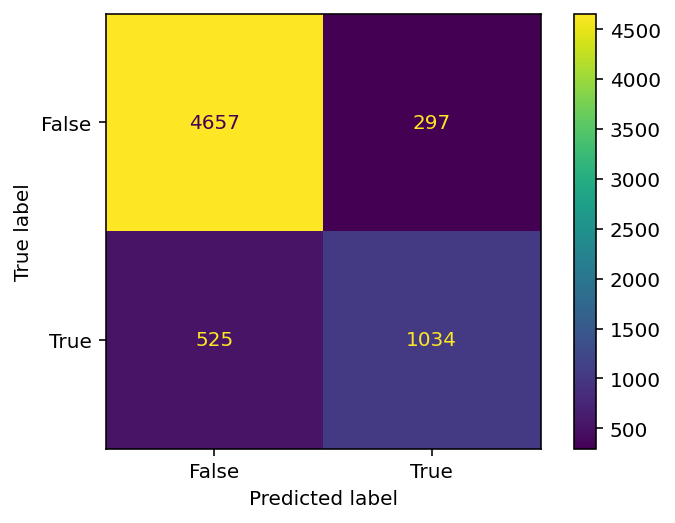

In [95]:
import shap
from sklearn.metrics import f1_score
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.metrics import plot_confusion_matrix
best_model = model.best_estimator_
y_pred = best_model.predict(X_test)
plot_confusion_matrix(best_model, X_test, y_test)
print("F1 Score for best model:", "{0:.3f}".format(f1_score(y_test,y_pred)))
print("Accuracy for best model:", "{0:.3f}".format(accuracy_score(y_test,y_pred)))

In [96]:
model1 = model.best_estimator_
explainer = shap.TreeExplainer(model1, X_train)
shap_values = explainer.shap_values(X_train)


100%|===================| 25994/26048 [00:52<00:00]        

diff: 0.47


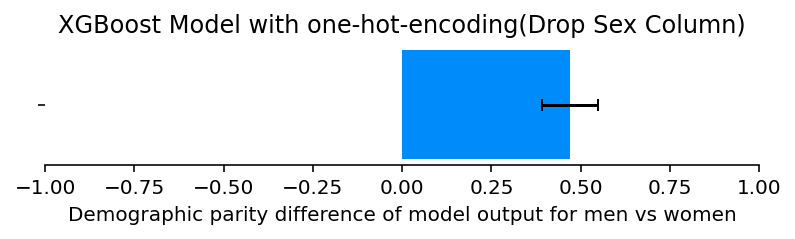

In [97]:
model_outputs = explainer.expected_value + shap_values.sum(1)
glabel = "Demographic parity difference of model output for men vs women"
title = "XGBoost Model with one-hot-encoding(Drop Sex Column)"
xmin = -1
xmax = 1
g13 = group_difference(shap_values.sum(1, keepdims=True), sex_train.astype(int),np.array(['']),title,xmin=xmin, xmax=xmax, xlabel=glabel,apply_sigmoid=True)
g13

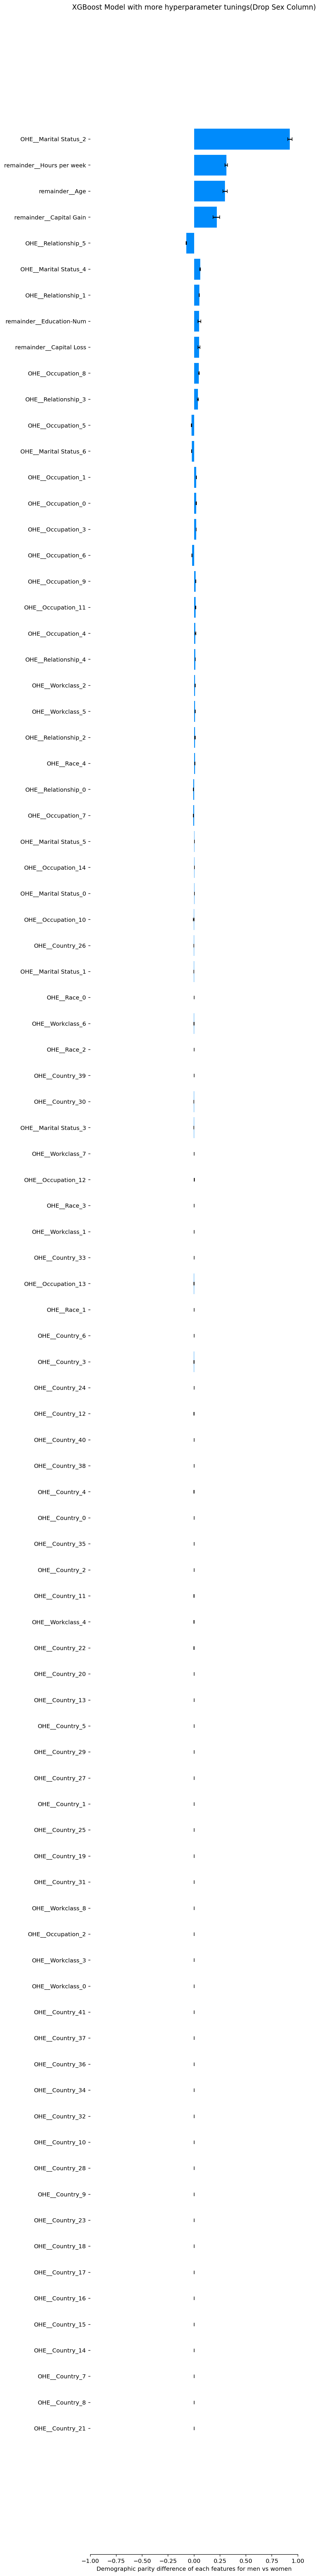

In [98]:
glabel = "Demographic parity difference of model output for men vs women"
title = "XGBoost Model with more hyperparameter tunings(Drop Sex Column)"
g14 =group_difference(shap_values, sex_train.astype(int), scaler.get_feature_names_out(),title,xmin, xmax, xlabel=slabel)
g14

In [85]:
X_display

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27.0,Private,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,United-States
32557,40.0,Private,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States
32558,58.0,Private,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,United-States
32559,22.0,Private,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20.0,United-States


In [86]:
X

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27.0,4,12.0,2,13,5,4,0,0.0,0.0,38.0,39
32557,40.0,4,9.0,2,7,4,4,1,0.0,0.0,40.0,39
32558,58.0,4,9.0,6,1,1,4,0,0.0,0.0,40.0,39
32559,22.0,4,9.0,4,1,3,4,1,0.0,0.0,20.0,39


### Disagreement measurement

#### Signed rank agreement for the demographic parity difference of the top k features

#### Signed rank correlation for the demographic parity difference of the top k features

#### Or find another metrics for unfairness ranking(considering the magnitude)

#### obeserve the patterns between model complexity and disagreement between demographic parity

#### compare among different ml models using these disagreement metrics

#### Find out the change of disagreement after dropping the most significant features.